In [1]:
using CairoMakie
using CSV
using DataFrames

# these are relative to 1 CSS px
inch = 96
pt = 4/3
cm = inch / 2.54
default_width = 9 * cm  # Column width

340.1574803149606

In [5]:
data = Dict()

for (name, prefix) in [
    ("diamond", "runs/C.extxyz_kgrid8_relax_scfres0.jld2"),
    ("silicon", "runs/Si.extxyz_kgrid8_relax_scfres0.jld2"),
    ("caesium chloride", "runs/CsCl.extxyz_kgrid8_relax_scfres0.jld2")
]
    data[name] = Dict(
        "dfpt"=>      DataFrame(CSV.File(prefix * "_elastic_dfpt_summary.csv")),
        "finitediff"=>DataFrame(CSV.File(prefix * "_elastic_finitediff_summary.csv")),
    )

    println(name)
    println(data[name]["dfpt"])
    println(data[name]["finitediff"])
end

diamond
6×7 DataFrame
 Row │ tol      Ecut     c11      c12      c44      stress                             dstress                           
     │ Float64  Float64  Float64  Float64  Float64  String                             String                            
─────┼───────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   1 │ 0.01        41.0  1057.07  125.376  563.907  [-1.1904996004676888e-5, -1.1300…  [0.0359290684349681, 0.004261454…
   2 │ 0.0001      41.0  1056.85  125.185  564.609  [3.297625278007917e-7, 3.4704025…  [0.0359215687584834, 0.004254960…
   3 │ 1.0e-6      41.0  1056.89  125.181  564.624  [1.8555238139559088e-9, 1.882008…  [0.03592283248423684, 0.00425482…
   4 │ 1.0e-8      41.0  1056.89  125.181  564.624  [-1.0378830122494221e-11, -9.631…  [0.03592283916774086, 0.00425482…
   5 │ 1.0e-10     41.0  1056.89  125.181  564.624  [-6.2366511580375476e-12, -6.216…  [0.03592283915954057, 0.00425482…
   6 │ 

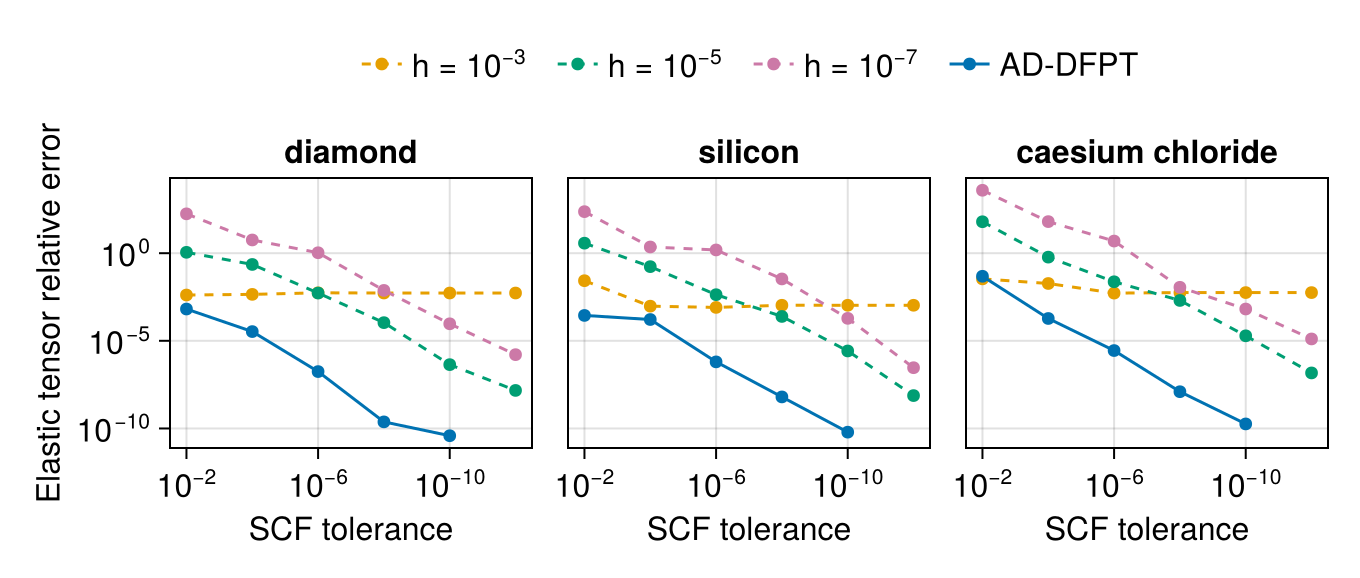

In [ ]:
fig = Figure(size=(2 * default_width, 0.85 * default_width), fontsize=12pt)

xticks = ([1e-2, 1e-6, 1e-10], [rich("10", superscript("−2")), 
                                rich("10", superscript("−6")), 
                                rich("10", superscript("−10"))])

ax1 = Makie.Axis(fig[1,1]; 
                title="diamond",
                xlabel="SCF tolerance", ylabel=rich("Elastic tensor relative error"),
                xscale=log10, yscale=log10, xreversed=true)
ax2 = Makie.Axis(fig[1,2], 
                title="silicon",
                xlabel="SCF tolerance",
                xscale=log10, yscale=log10, xreversed=true)
ax3 = Makie.Axis(fig[1,3], 
                title="caesium chloride",
                xlabel="SCF tolerance",
                xscale=log10, yscale=log10, xreversed=true)
hideydecorations!(ax2, grid=false)
hideydecorations!(ax3, grid=false)
linkaxes!(ax1, ax2, ax3)

ax1.xticks = xticks
ax2.xticks = xticks
ax3.xticks = xticks

colors = Makie.wong_colors()

for (ax, name) in [
    (ax1, "diamond"),
    (ax2, "silicon"),
    (ax3, "caesium chloride"),
]
    # limits!(ax, (5e-2, 5e-13), (1e-9, 1e3))

    dfpt = data[name]["dfpt"]
    fd = data[name]["finitediff"]

    # The most precise reference is DFPT with the tightest SCF tolerance
    weights = [3, 6, 3]  # corresponding to C_11, C_12, C_44 for a cubic crystal
    C_ref = [dfpt.c11[end], dfpt.c12[end], dfpt.c44[end]]
    C_ref_norm = sqrt(sum(weights .* C_ref.^2))  # Frobenius norm of 6x6 elastic tensor

    # For each other elastic constants we compute the relative error with respect to the reference
    # in the Frobenius norm of the corresponding 6x6 elastic tensor
    for (i, (h, fd_h)) in enumerate(pairs(groupby(fd, :h)))
        color = colors[i + 1]
        errors = Float64[]
        for row in eachrow(fd_h)
            C = [row.c11, row.c12, row.c44]
            push!(errors, sqrt(sum(weights .* (C - C_ref).^2)) / C_ref_norm)
        end
        scatterlines!(ax, fd_h.tol, errors,
            label=rich("h = 10", superscript("−$(abs(Int(log10(h.h))))")),
            linestyle=:dash, color=color)
    end

    errors_dfpt = Float64[]
    for row in eachrow(dfpt[1:end-1, :])
        C = [row.c11, row.c12, row.c44]
        push!(errors_dfpt, sqrt(sum(weights .* (C - C_ref).^2)) / C_ref_norm)
    end
    scatterlines!(ax, dfpt.tol[1:end-1], errors_dfpt,
        label="AD-DFPT", color=colors[1])
end
Legend(fig[0,1:3], ax2, orientation=:horizontal, framevisible=false)

fig

In [30]:
save("elastic_constants_scf_convergence.pdf", fig)

CairoMakie.Screen{PDF}
